# Pareto-like plots

In [1]:
from recbole.quick_start import load_data_and_model
import pandas as pd
from tqdm import tqdm
from recbole.utils.case_study import full_sort_topk
import os
from recsyslearn.accuracy.metrics import NDCG
from recsyslearn.dataset.utils import find_relevant_items
from recsyslearn.beyond_accuracy.metrics import Coverage
from recsyslearn.beyond_accuracy.metrics import BeyondAccuracyMetric
from recsyslearn.fairness.metrics import KullbackLeibler
from recsyslearn.dataset.segmentations import PopularityPercentage
from recsyslearn.dataset.segmentations import InteractionSegmentation
from recsyslearn.dataset.segmentations import Segmentation
# from recsyslearn.dataset.segmentations import ActivitySegmentation
import numpy as np
import json
import seaborn as sns

In [2]:
from recsyslearn.fairness.metrics import FairnessMetric

In [3]:
from recsyslearn.fairness.utils import eff_matrix
from recsyslearn.utils import check_columns_exist

In [4]:
class Novelty(BeyondAccuracyMetric):

    """
    Novelty evaluator for recommender systems.
    Used formula can be found here https://doi.org/10.1007/s13735-018-0154-2
    where popularity is defined in terms of the segmentation of the item groups
    (e.g. short head -> 3, mid tail   -> 2, long tail  -> 1)
    or in terms of percentage of user-item interactions.
    """

    @classmethod
    def evaluate(cls, top_n: pd.DataFrame, popularity_definition='group') -> pd.Series:
        """
        Compute the novelty of a model by using its recommendation list and the segmented item groups.
        Parameters
        ----------
        top_n : pd.DataFrame
            Top-N recommendations' lists for every user with items or users already segmented.
        popularity_definition: str
            Either 'group' or 'percentage', to choose whether popularity is computed in terms of
            segmenting items/users according to the distribution of user-item interactions
            or if it is defined as the percentage of user-item interactions.
        Raises
        ------
        ColumnsNotExistException
            If top_n not in the form ('user', 'item', 'rank', popularity_definition).
        Return
        ------
        The pd.Series with the novelty computed for each user. The user ID is the index of the pd.Series.
        """

        check_columns_exist(
            top_n, ['user', 'item', 'rank', popularity_definition])
        top_n.loc[:, popularity_definition] = pd.to_numeric(
            top_n.loc[:, popularity_definition])
        top_n = top_n.groupby('user')[popularity_definition].apply(
            lambda x: np.mean(- np.log2(x)))
        
        return top_n.reset_index()

In [5]:
class ActivitySegmentation(Segmentation):

    """
    Segmentation of users based on their number of interaction.
    """

    @classmethod
    def segment(cls, dataset: pd.DataFrame, proportions=None, min_interaction: int = 0) -> pd.DataFrame:
        """
        Segmentation of users based on their interactions with different items.
        Parameters
        ----------
        dataset : pd.DataFrame
            The complete dataset.
        proportions : list, default [0.8, 0.2]
            The proportion of interactions wanted for every group.
        min_interaction : int, default 0
            The minimum number of interaction allowed per user. Users below this threshold will be removed.
        Raises
        ------
        SegmentationNotSupportedException
            If len(proportion) not in (1, 2, 3).
        WrongProportionsException
            If sum(proportion) is not 1, which means it doesn't cover all the items/users.
        Return
        ------
        DataFrame with users and belonging group.
        """

        if proportions is None:
            proportions = [0.1, 0.9]

        if len(proportions) == 1:
            return dataset

        if len(proportions) not in (2, 3):
            raise SegmentationNotSupportedException(
                "Number of supported group is between 1 and 3.")

        if np.sum(proportions * 10) / 10 != 1:
            raise WrongProportionsException()

        user_groups = dataset.groupby('user').size().reset_index(name='count')
        user_groups = user_groups.loc[user_groups['count']
                                      >= min_interaction, :]

        user_groups.loc[:, 'count'] = user_groups.loc[:, 'count'].apply(
            lambda x: x + np.random.choice(list(range(10))))
        user_groups = user_groups.sort_values('count', ascending=False)
        user_groups.loc[:, 'count'] = np.arange(user_groups.shape[0]) + 1
        first_thr = np.rint(proportions[0] * user_groups.shape[0])
        second_thr = np.rint(proportions[1] * user_groups.shape[0]) + first_thr
        first_thr = first_thr if first_thr > 0 else 1
        first_group = user_groups.loc[user_groups['count'] <=
            first_thr, 'user']
        second_group = user_groups.loc[user_groups['count'].lt(
            second_thr), 'user']

        conditions = [user_groups['user'].isin(
            first_group), user_groups['user'].isin(second_group)]
        choices = (1, 2)
        default = len(proportions)
        user_groups.loc[:, 'group'] = np.select(
            conditions, choices, default=default)

        return user_groups[['user', 'group']].astype({'user': str, 'group': str})

In [6]:
class UserLevelEntropy(FairnessMetric):

    """
    Entropy evaluator for recommender systems, returning an entropy value for each user.
    """

    def evaluate(self, top_n: pd.DataFrame, rel_matrix: pd.DataFrame = None) -> float:
        """
        Compute the entropy of a model by using its recommendation list.


        Parameters
        ----------
        top_n : pd.DataFrame
            Top N recommendations' lists for every user with items or users already segmented.

        rel_matrix : pd.DataFrame, default None
            Relevant items for users. It could be, for example, the items with a rating >= threshold.


        Raises
        ------
        ColumnsNotExistException
            If top_n not in the form ('user', 'item', 'rank', 'group').


        Return
        ------
        The computed entropy.
        """

        check_columns_exist(top_n, ['user', 'item', 'rank', 'group'])

        top_n = eff_matrix(
            top_n, rel_matrix) if rel_matrix is not None else top_n

        top_n = top_n.groupby(['user', 'group'], as_index=False).sum()
        top_n['sum'] = [top_n[top_n.user == user]['rank'].sum() for user in top_n.user.values]

        top_n['rank'] = top_n['rank'] / top_n['sum']
        top_n['rank'] = - top_n['rank'] * np.log2(top_n['rank'])

        top_n = top_n[['user', 'rank']].groupby(['user'], as_index=False).sum()

        return top_n

In [7]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [10]:
harmful_list = [0.00, 0.01, 0.05, 0.10]
ITEM_TARGET = [0.6, 0.3, 0.1]
ITEM_TARGET_DF = pd.DataFrame()
ITEM_TARGET_DF['group'] = list(range(1, len(ITEM_TARGET) + 1))
ITEM_TARGET_DF['target_representation'] = ITEM_TARGET


USER_TARGET = [0.6, 0.3, 0.1]
USER_TARGET_DF = pd.DataFrame()
USER_TARGET_DF['group'] = list(range(1, len(USER_TARGET) + 1))
USER_TARGET_DF['target_representation'] = USER_TARGET

model_dict = {
    'BPR': 'bpr',
    'ItemKNN': 'iknn',
    'MultiVAE': 'vae_hyperparams',
}


# DATASET_LIST = ['ml-100k']
BASE_FOLDER = '/home/marta/jku/activity_fair/'

metrics_df = pd.DataFrame(columns=[
    'model',
    'harm',
    'dataset',
    'NDCG@10_full',
    'NDCG@10_core',
    'coverage',
    'novelty',
    'kl_item',
    'kl_user',
])

MODEL = 'MultiVAE'
MODEL_SUBFOLDER = model_dict[MODEL]
    
DATASET = 'ml-100k'

FULL_DATASETS_FOLDER = BASE_FOLDER + f'datasets/full_datasets/{DATASET}/'

BINARIZED_CORE_INTERACTION_FILE = FULL_DATASETS_FOLDER + f'{DATASET}_bin_core.inter'
binarized = pd.read_csv(BINARIZED_CORE_INTERACTION_FILE, sep='\t')
binarized.columns = ['user', 'item']

ITEM_GROUPS = InteractionSegmentation().segment(
    binarized, 
    proportions=ITEM_TARGET,
)
ITEM_GROUPS = ITEM_GROUPS.astype({
    'item': int,
})

### 
harmful = 0.10
DS_STRING = f'{DATASET}_harm{str(int(100*harmful)).zfill(2)}'
TEST_DATA_FILE = f'{BASE_FOLDER}/test/{DS_STRING}.tsv'
TEST_DATASET_CORE = pd.read_csv(TEST_DATA_FILE, sep='\t')
POS_ITEMS_TEST_CORE = find_relevant_items(TEST_DATASET_CORE).astype({
    'user': str,
})

test_users_core = POS_ITEMS_TEST_CORE.user.values
# print(test_users_core)
# print(binarized.user.info)
binarized_core = binarized[binarized.user.astype(str).isin(test_users_core)]

# print(binarized_core.head())
USER_GROUPS = ActivitySegmentation().segment(
    binarized_core, 
    proportions=USER_TARGET,
)
USER_GROUPS = USER_GROUPS.astype({
    'user': str,
})
# UserKL should be restricted to core-users only, in order to be comparable
# USER_GROUPS = USER_GROUPS[USER_GROUPS.user.isin(test_users_core)]


for harmful in harmful_list:

    DS_STRING = f'{DATASET}_harm{str(int(100*harmful)).zfill(2)}'

    row_dict = {}
    row_dict['model'] = model_dict[MODEL]
    row_dict['dataset'] = DATASET
    row_dict['harm'] = harmful


    MODEL_FOLDER = f'{BASE_FOLDER}saved/{MODEL_SUBFOLDER}/{DS_STRING}/'
    
    for RECLIST_FILE in os.listdir(MODEL_FOLDER + '/'):
        if RECLIST_FILE[-3:]=='tsv':
            top_k_df = pd.read_csv(MODEL_FOLDER + '/' + RECLIST_FILE, sep='\t')
            top_k_df = top_k_df.astype({
                'user': str,
                'item': int,
            })

            TEST_DATA_FILE = f'{BASE_FOLDER}/test/{DS_STRING}.tsv'
            TEST_DATASET_RANK = pd.read_csv(TEST_DATA_FILE, sep='\t')
            POS_ITEMS_TEST = find_relevant_items(TEST_DATASET_RANK).astype({
                'user': str,
            })
            test_users = top_k_df.user.values

            POS_ITEMS_TEST = POS_ITEMS_TEST.astype({
                'user': str,
            })
            POS_ITEMS_TEST = POS_ITEMS_TEST[POS_ITEMS_TEST.user.isin(test_users)]

            # NDCG Full
            ndcg = NDCG().evaluate(
                top_n=top_k_df,
                pos_items=POS_ITEMS_TEST,
                ats=(10,),
            ).mean()
            row_dict['NDCG@10_full'] = ndcg['NDCG@10']


            # NDCG Core
            POS_ITEMS_TEST_CORE = POS_ITEMS_TEST[POS_ITEMS_TEST.user.isin(test_users_core)]
            top_k_core_df = top_k_df[top_k_df.user.isin(test_users_core)]

            ndcg = NDCG().evaluate(
                top_n=top_k_core_df,
                pos_items=POS_ITEMS_TEST_CORE,
                ats=(10,),
            )

            n_users = len(ndcg)

            row_dict['NDCG@10_core'] = ndcg.mean()['NDCG@10']


            # COVERAGE
            items = list(binarized['item'].unique())
            coverage = Coverage.evaluate(
                top_n=top_k_df,
                items=items,
            )
            row_dict['coverage'] = coverage

            # NOVELTY

            ITEM_POPULARITY = PopularityPercentage().segment(binarized, group='item')
            popularity_top_k = top_k_df.merge(ITEM_POPULARITY, how='inner', left_on='item', right_on='item')
            novelty = Novelty.evaluate(
                top_n=popularity_top_k,
                popularity_definition='percentage',
            )

            novelty.columns = ['user', 'novelty']
            row_dict['novelty'] = novelty.novelty.mean()

            # Item KL
            item_segmented_top_k = top_k_df.merge(ITEM_GROUPS, how='inner', left_on='item', right_on='item')
            item_segmented_top_k['rank'] = item_segmented_top_k['rank'].astype(float)
            item_segmented_top_k['group'] = item_segmented_top_k['group'].astype(int)

            item_kl = KullbackLeibler().evaluate(
                top_n=item_segmented_top_k,
                target_representation=ITEM_TARGET_DF,
            )
            row_dict['kl_item'] = item_kl
            # User KL
            user_segmented_top_k = top_k_df.merge(USER_GROUPS, how='inner', left_on='user', right_on='user')
            user_segmented_top_k['rank'] = user_segmented_top_k['rank'].astype(float)
            user_segmented_top_k['group'] = user_segmented_top_k['group'].astype(int)

            user_segmented_rel_matrix = TEST_DATASET_RANK.astype({'user': str}).merge(USER_GROUPS, how='inner', left_on='user',
                                                                  right_on='user')

            user_segmented_rel_matrix['group'] = user_segmented_rel_matrix['group'].astype(int)

            user_kl = KullbackLeibler().evaluate(
                top_n=user_segmented_top_k,
                target_representation=USER_TARGET_DF,
                rel_matrix=user_segmented_rel_matrix,
            )
            row_dict['kl_user'] = user_kl

            metrics_df.loc[len(metrics_df)] = row_dict

In [28]:
pd.reset_option("display.precision")
metrics_df_one = metrics_df[metrics_df.harm==0.]

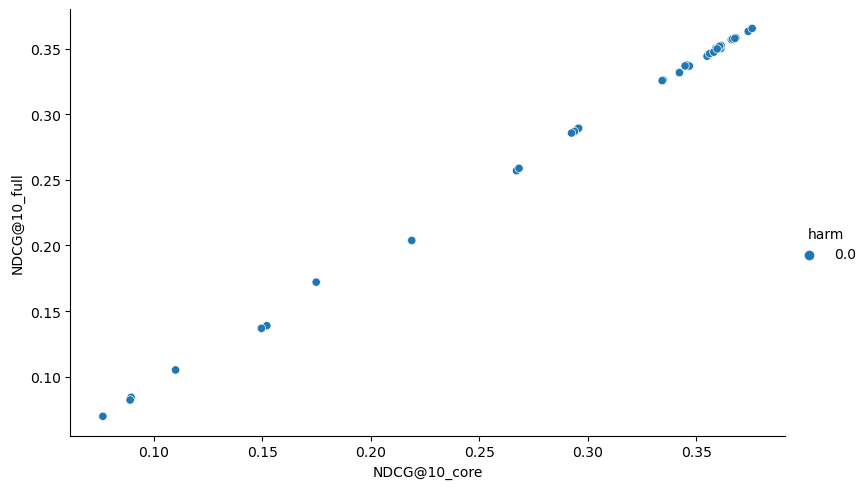

In [29]:
sns.relplot(data=metrics_df_one, x='NDCG@10_core', y='NDCG@10_full', hue='harm', aspect=1.61)

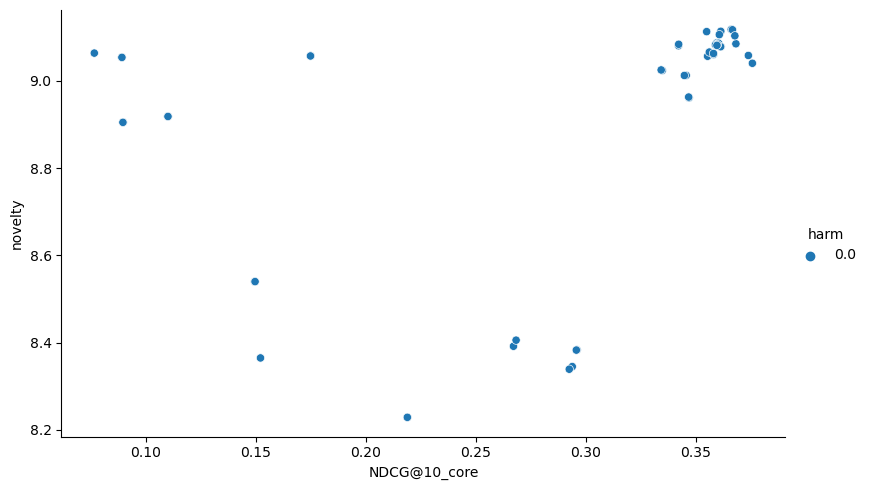

In [30]:
sns.relplot(data=metrics_df_one, x='NDCG@10_core', y='novelty', hue='harm', aspect=1.61)

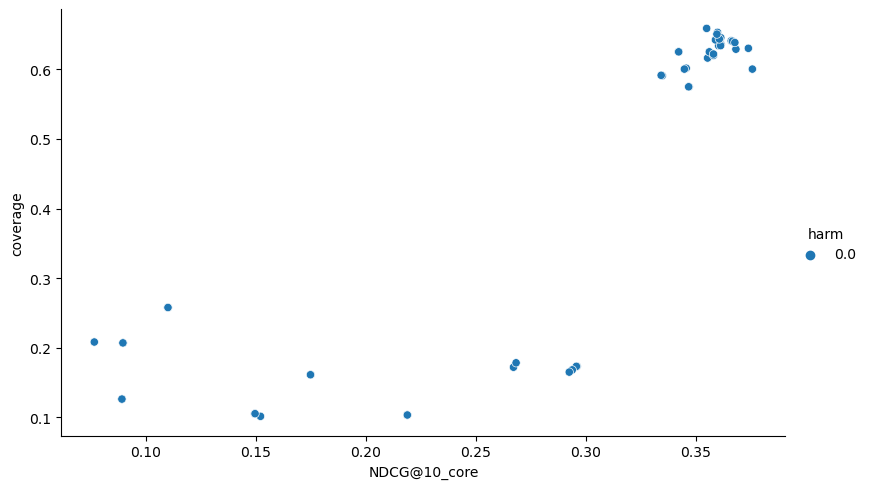

In [31]:
sns.relplot(data=metrics_df_one, x='NDCG@10_core', y='coverage', hue='harm', aspect=1.61)

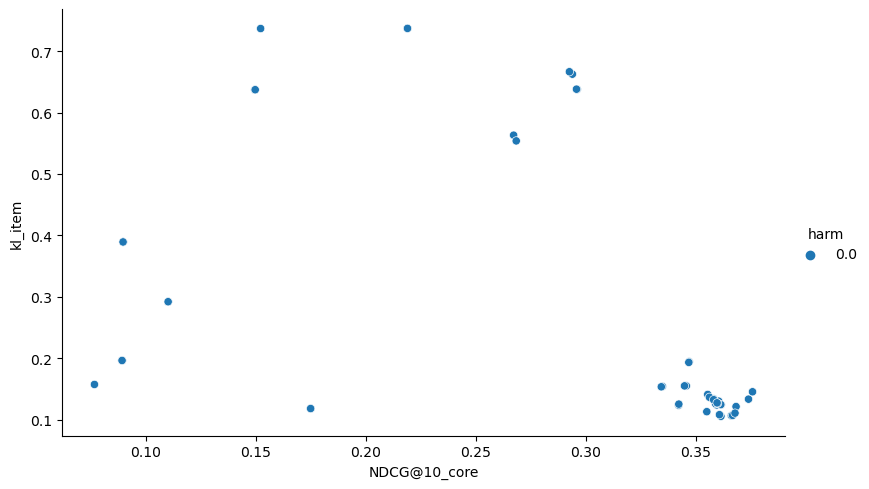

In [35]:
sns.relplot(data=metrics_df_one, x='NDCG@10_core', y='kl_item', hue='harm', aspect=1.61)

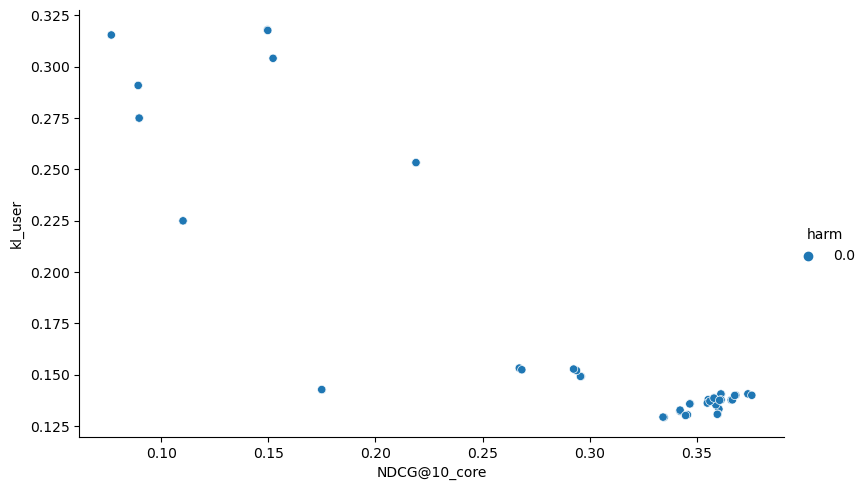

In [36]:
sns.relplot(data=metrics_df_one, x='NDCG@10_core', y='kl_user', hue='harm', aspect=1.61)

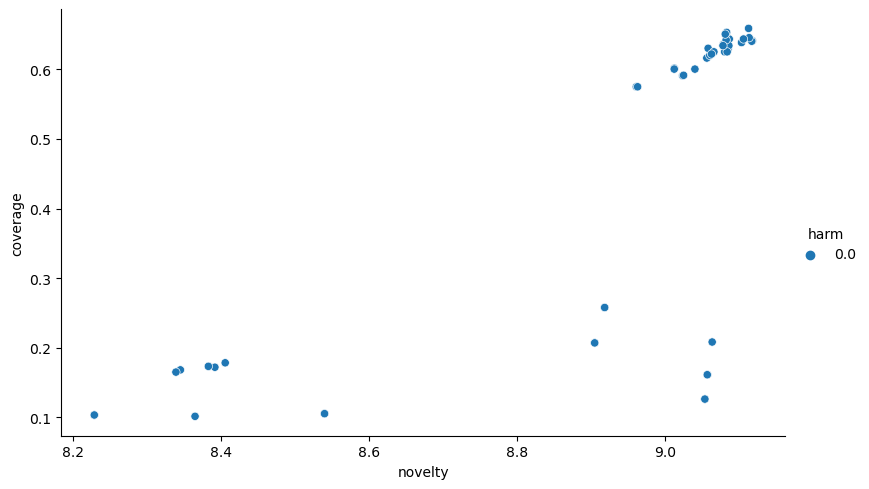

In [32]:
sns.relplot(data=metrics_df_one, x='novelty', y='coverage', hue='harm', aspect=1.61)

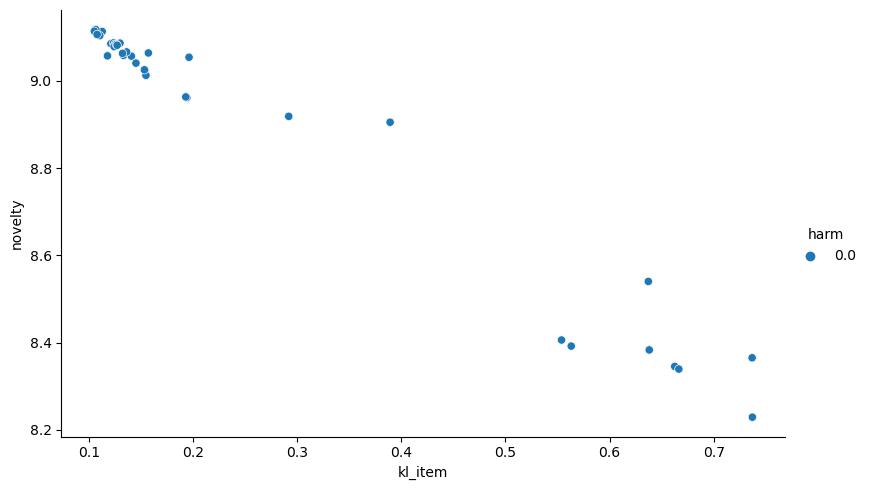

In [33]:
sns.relplot(data=metrics_df_one, x='kl_item', y='novelty', hue='harm', aspect=1.61)

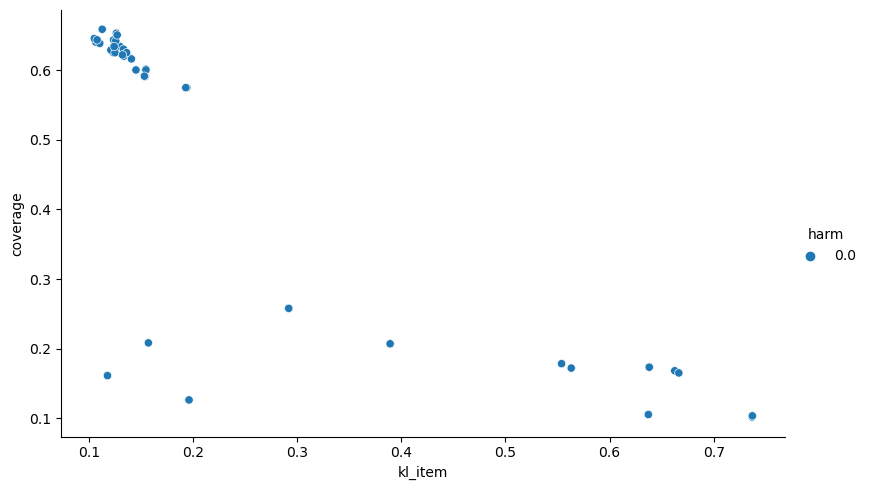

In [34]:
sns.relplot(data=metrics_df_one, x='kl_item', y='coverage', hue='harm', aspect=1.61)

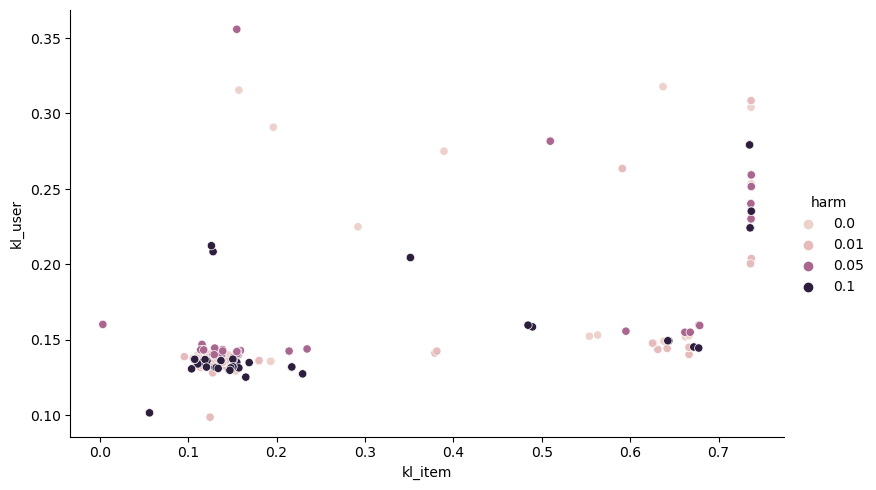

In [27]:
metrics_df.harm = metrics_df.harm.astype(float)
sns.relplot(data=metrics_df, x='kl_item', y='kl_user', hue='harm', aspect=1.61)